In [1]:
#Data analysis & manipulation
import pandas as pd
from sklearn.decomposition import IncrementalPCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

#Data computation
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import MiniBatchKMeans
from sklearn.mixture import GaussianMixture

#Data visualization
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import umap
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram

#Model evaluation
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

#Utils
from tqdm import tqdm
SEED = 122212112

In [2]:
spotify = pd.read_csv('./dataset/spotify_tracks_reduced.csv')
spotify.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Anime,Yuki Hayashi,HERO A,6LoC0DAzeIET4iA9gXG2Ly,44,0.02270,0.552,195667,0.958,0.127,F#,0.128,-5.292,Minor,0.0671,120.033,4/4,0.593
1,Country,Hayes Carll,If I May Be So Bold,6tVvfvsV7aIhTwKGy6c9R7,38,0.15000,0.382,190619,0.742,0.000,A,0.173,-4.857,Major,0.0740,207.540,4/4,0.691
2,Hip-Hop,Pitbull,Hey Baby (Drop It to the Floor),3rfhI32Il2hVRKDkuGeeen,63,0.04350,0.595,234453,0.913,0.000,A#,0.259,-3.428,Minor,0.0884,128.021,4/4,0.762
3,Comedy,Maria Bamford,What I Worship,7JF9TagvvS4GmCB1SHUM38,23,0.71800,0.540,90280,0.847,0.000,F#,0.726,-7.445,Major,0.9410,99.829,4/4,0.489
4,World,Citipointe Live,The Christ (Live),4lMGWRMsW0pGsUD4YlHs7k,32,0.00228,0.215,404800,0.457,0.000,G,0.114,-7.137,Major,0.0309,148.773,4/4,0.130


We do not want the track_id column

In [3]:
spotify.drop(['track_id'], axis=1, inplace=True)

Let's transform the categorical into numerical variables

In [4]:
#The musical key scale can be represented as an ordinal variable
musical_scale = {
    'C' :   1.,
    'C#':   1.5,
    'D' :   2.,
    'D#':   2.5,
    'E' :   3.,
    'F' :   4.,
    'F#':   4.5,
    'G' :   5.,
    'G#':   5.5,
    'A' :   6.,
    'A#':   6.5,
    'B' :   7.
}

spotify['key'] = spotify['key'].apply(lambda k: musical_scale[k])

In [5]:
def dummify(dataset, columns):
    for c in columns:
        dataset = dataset.join(pd.get_dummies(dataset[c], drop_first=True))
        dataset.drop([c], axis=1, inplace=True)

    return dataset

spotify = dummify(spotify, ['mode', 'time_signature'])

In [6]:
spotify.head(0)

,genre,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,speechiness,tempo,valence,Minor,1/4,3/4,4/4,5/4


In [7]:
dataset = spotify.loc[:, spotify.columns[3:]]

Normalizing the variables

In [8]:
scaler = MinMaxScaler().fit(dataset)
dataset = scaler.transform(dataset)

Defining the metrics function

In [27]:
def clustering_metrics(dataset, model_str, range_, plot=False): 
    elb, sil, c_h, d_b = [], [], [], []

    for k in tqdm(range_):
        if model_str == 'kmeans': model = MiniBatchKMeans(n_clusters=k, random_state=SEED).fit(dataset)
        
        centroids = model.cluster_centers_
        labels = model.predict(dataset)

        #Calculating silhouette, Calinski-Harabasz and Davies-Bouldin metrics
        sil.append(silhouette_score(dataset, labels))
        c_h.append(calinski_harabasz_score(dataset, labels))
        d_b.append(davies_bouldin_score(dataset, labels))

        #Calculating shoulder metric
        curr_elb = 0
        for i in range(len(dataset)):
            curr_center = centroids[labels[i]]
            curr_elb += (dataset[i, 0] - curr_center[0]) ** 2 + (dataset[i, 1] - curr_center[1]) ** 2

        elb.append(curr_elb)

    metrics = {
        'elbow_score'       : elb,
        'silhouette_score'  : sil,
        #'calinski-harabasz' : c_h,
        #'davies-bouldin'    : d_b
    }

    if plot:
        plt.figure(figsize=(6, 10))
        for i, (title, values) in enumerate(zip(metrics.keys(), metrics.values())):
            plt.subplot(2, 2, i+1)
            plt.title(title)
            plt.xticks(range_)
            plt.plot(range_, values, 'b-')

    return metrics

# Hierarchical clustering

In [22]:
metrics = clustering_metrics(dataset, 'hierarchical', range(2, 30, 2), plot=True)

  0%|          | 0/14 [00:03<?, ?it/s]


AttributeError: 'AgglomerativeClustering' object has no attribute 'cluster_centers_'

# Partitional clustering

Using K-Means, actually MiniBatchKMeans

100%|██████████| 14/14 [00:19<00:00,  1.41s/it]


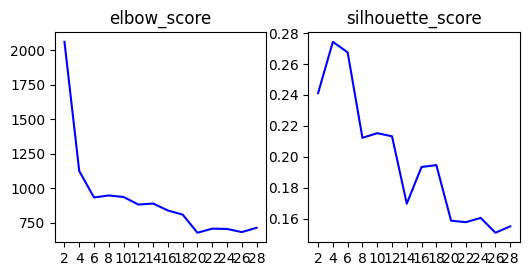

In [16]:
metrics = clustering_metrics(dataset, 'kmeans', range(2, 30, 2), plot=True)

# Probabilistic clustering

# Visualization

In [25]:
def visualize_clusters(model, n_clusters, reducer=TSNE):
    reducer = reducer(n_components=2, random_state=SEED)

    if model is MiniBatchKMeans:            model = model(n_clusters=n_clusters, random_state=SEED)
    elif model is AgglomerativeClustering:  model = model(n_clusters=n_clusters)

    reduced_dataset = reducer.fit_transform(dataset)
    clusters = model.fit_predict(reduced_dataset)
    
    if model is MiniBatchKMeans: 
        plt.xlabel('t-sne component 1')
        plt.ylabel('t-sne component 2')
        sns.scatterplot(x=reduced_dataset[:, 0], y=reduced_dataset[:, 1], hue=clusters, palette='pastel', legend=True)

c:\Users\adrig\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\adrig\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


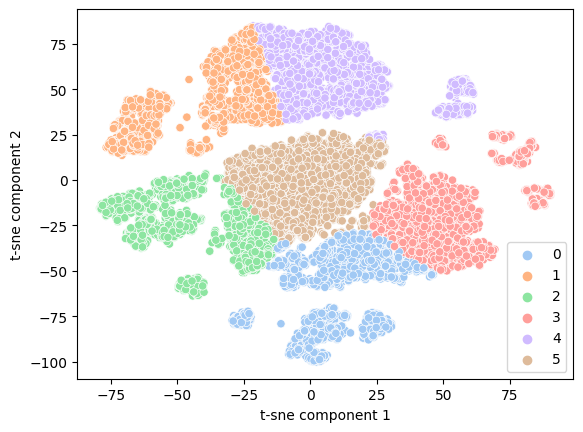

In [26]:
method = MiniBatchKMeans
n_clusters = 6
reducer = TSNE
# reducer = umap.UMAP()

visualize_clusters(method, n_clusters, reducer)